# Bayes Theorem and Kernel density estimation.

In [44]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
from scipy.stats import norm

import warnings
warnings.filterwarnings('ignore')
np.random.seed(42)

%matplotlib inline

---
## Bayes Theorem: the biased coin flip

Let's simulate a random coin flip 1000 times:

In [45]:
coin_flips = np.random.randint(2, size=1000)

If the coin is fair, then we expect to have equally likely heads or tails outcomes:

In [46]:
np.mean(coin_flips)

0.51

A coin flip is an example of a Bernoulli trail, i.e. a random experiment with only two outcomes (usually called a “Success” or a “Failure”), having the **Bernoulli** distribution as discrete probability density function (or probability mass function, **PMF**).


Let's define the pmf, a function that computes the probability of observing a specific outcome $x$ for a random variable following the Bernoulli distribution with a given parameter $p$ for success probability.

In [47]:
def bernoulli_pmf(x, p):
    return p**x * (1-p) ** (1-x)

We now would like to give an estimate of the parameter $p$ given a sample of outcomes from a Bernoulli trial. We thus want to perform a Maximum Likelihood Estimation (**MLE**) of $p$ (a simple theoretical review: https://en.wikipedia.org/wiki/Maximum_likelihood_estimation).

#### TODO (1 point):
Next, let's a function that returns the MLE of the parameter $p$ of the Bernoulli distribution, given a sample of outcomes $X$ assumed to come from a Bernoulli trial.

In [48]:
def MLE_bernoulli_p(X, plist=np.linspace(0,1,100)):
    # TODO: Fill in the function
    # ide a loop over the values for p, found in plist, a representative for 100 probabilities
    values = []
    for p in plist:
        value = np.product(st.bernoulli.pmf(X, p)) # likelihood for this p
        values.append(value)
    
    return np.array(values)
        

#### Likelihood as a function of $p$, for the coin flip experiment (the *coin_flips* sample).

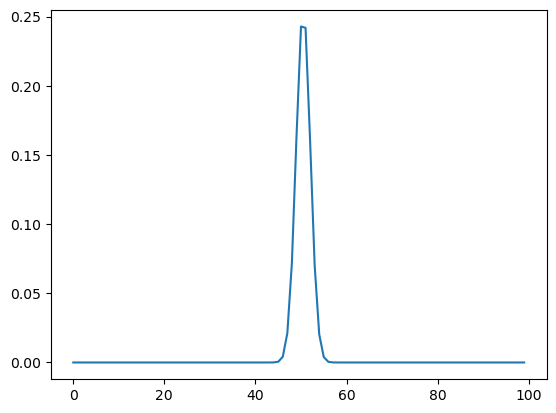

In [49]:
likelihood = MLE_bernoulli_p(coin_flips)
likelihood = likelihood / sum(likelihood)

plt.plot([i for i in range(len(likelihood))], likelihood)

### Maximum Likelihood estimate
Next, we give a maximum likelihood estimate $\hat{p}$ of Bernoulli's $p$, for the sample of outcomes we defined above for the coin flip experiment (the *coin_flips* sample).

In [50]:
# find location of best prob: argmax, then divide through 100
np.argmax(MLE_bernoulli_p(coin_flips)) / len(MLE_bernoulli_p(coin_flips))

0.5

#### Example outcome of 4 tails:
Let's now consider an experiment with 4 coin flips resulting in 4 tails. Compute MLE Bernoulli's $p$, $\hat{p}$, for these outcomes. If we sample the Bernoulli distribution with $p=\hat{p}$, we would get a biased coin, always resulting in tails. Check this by printing the expected outcomes if we flip the biased coin for another 40 trials.

In [51]:
All_tails_flip = np.ones(4) # 4 tails
phat = MLE_bernoulli_p(All_tails_flip)[np.argmax(MLE_bernoulli_p(All_tails_flip))]
phat

1.0

#### Including prior belief about a biased coin

In [52]:
N = 40

# Compute the next N outcomes of a Bernoulli trial with p=hat{p}
future_flips = []# list of outcomes of the biased coin
future_flips = list(np.random.binomial(1, phat, N))

print(f'Next {N} outcomes:n\n{future_flips}')

Next 40 outcomes:n
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


A sample of just 4 outcomes could be too small. We should include our prior belief about the coin. Let's start by considering the case of flipping a fair and an unfair coin.

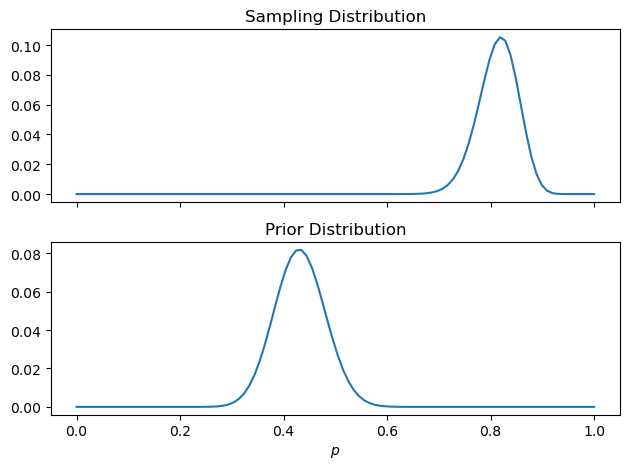

In [53]:
params = np.linspace(0,1,100)

fair_flips = np.random.binomial(n=1, p=.5, size=100)
p_fair = np.array([np.product(st.bernoulli.pmf(fair_flips, p)) for p in params])
p_fair = p_fair / np.sum(p_fair)

unfair_flips = np.random.binomial(n=1, p=.8, size=100)
p_unfair = np.array([np.product(st.bernoulli.pmf(unfair_flips, p)) for p in params])
p_unfair = p_unfair / np.sum(p_unfair)

fig, ax = plt.subplots(2, 1, sharex=True)
ax[0].plot(params, p_unfair); ax[0].set_title('Sampling Distribution')
ax[1].plot(params, p_fair); ax[1].set_title('Prior Distribution')
ax[1].set_xlabel('$p$')
plt.tight_layout()

The fair coin results in a roughly equal number of heads and tails. On the other hand, the biased, unfair coin results in more tails. Now, we compute the posterior distribution, to see how we gradually change our belief about the coin based on the experiments.

### Posterior distribution by Bayes theorem
Let's define the function that calculates the posterior distribution computed by means of Bayes theorem. Then, the function to produce a plot showing the three distributions (sampling, prior, and posterior) for fair and unfair flips samples of size 100 and 50, respectively. We, assume the unfair flips result from a Bernoulli trial with $p=0.9$.

In [54]:
def bern_post(fair_flips, unfair_flips, n_params=100):
    params = np.linspace(0, 1, n_params)

    # likelihood for the unfair coin
    unfair_likelihood = MLE_bernoulli_p(unfair_flips)

    # likelihood for the fair coin (i.e. the prior)
    prior = MLE_bernoulli_p(fair_flips)

    # compute the posterior
    posterior = unfair_likelihood * prior

     
    fig, ax = plt.subplots(3, 1, sharex=True, figsize=(8,8))
    ax[0].plot(params, unfair_likelihood); ax[0].set_title('Sampling Distribution')
    ax[1].plot(params, prior); ax[1].set_title('Prior Distribution')
    ax[2].plot(params, posterior); ax[2].set_title('Posterior Distribution')
    ax[2].set_xlabel('p')
    plt.tight_layout()
     
    return posterior

### Investigate Bayes theorem with new sample

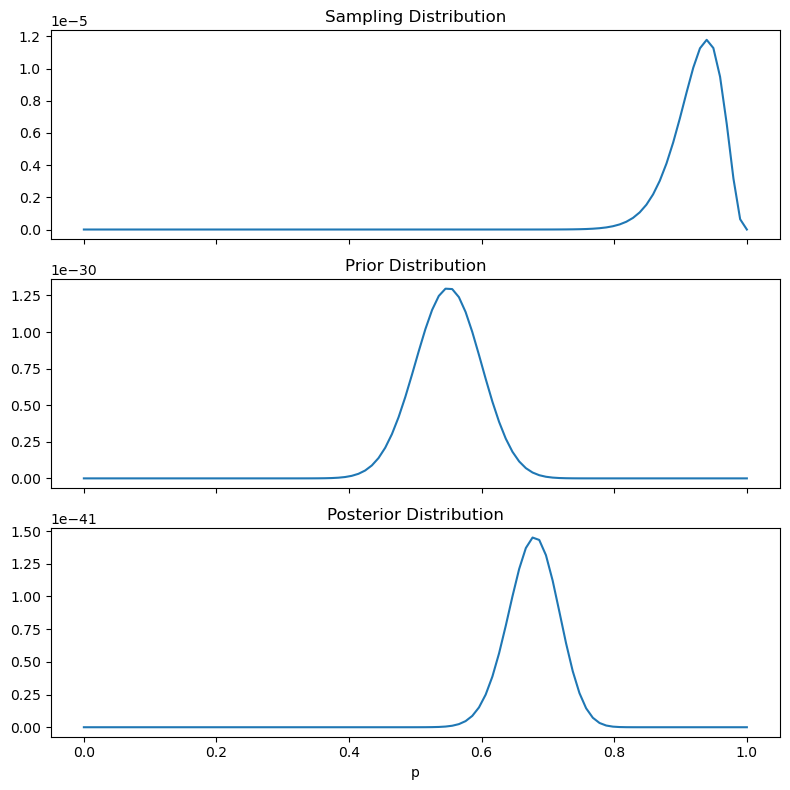

In [55]:
# new sample of fair flips (size=100)
fair_flips = np.random.binomial(1,0.5,100)

# new sample of unfair flips (size=50; p=0.9)
unfair_flips = np.random.binomial(1,0.9,50)

_ = bern_post(fair_flips=fair_flips, unfair_flips=unfair_flips)



### What happens when we increase sample size?
Let's, see what changes by increasing the size of the unfair flips sample from 50 to 1000. As in previous the task, we plot the three distributions using the function above. Finally, we do the same using as unfair flips sample the *All_tails_flips* one previously defined (4 outcomes, all tails).

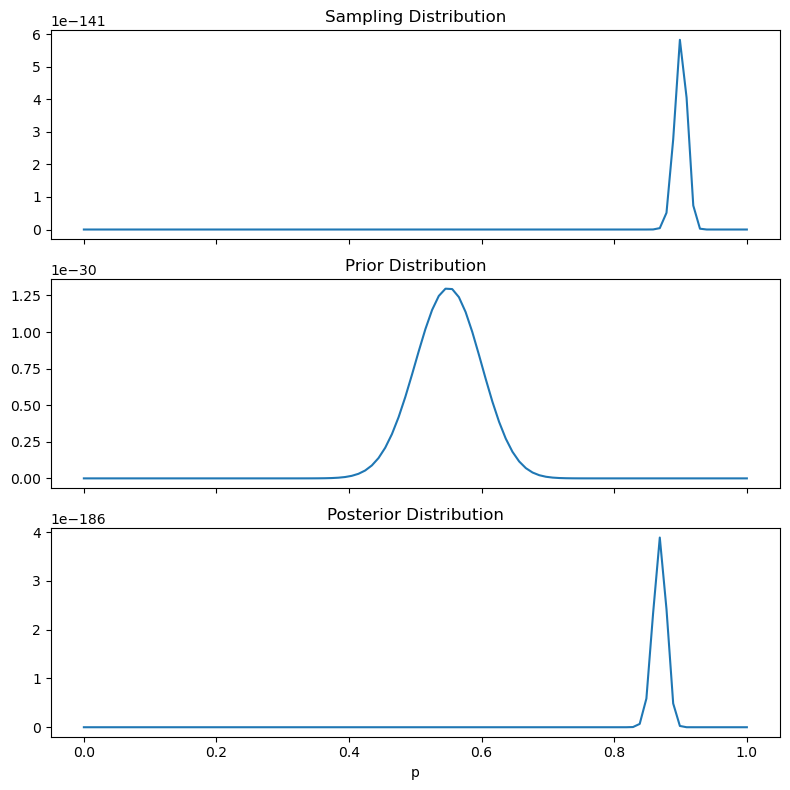

In [56]:
# Sample 1000 Biased coin flips.

unfair_flips = np.random.binomial(1,0.9,1000)
_ = bern_post(fair_flips=fair_flips, unfair_flips=unfair_flips)

In summary, when the unfair flips sample size is larger, the posterior distribution becomes more focused and informative. The increased sample size strengthens our estimation by providing a more accurate representation of the underlying distribution, leading to a more confident assessment of the parameter value.

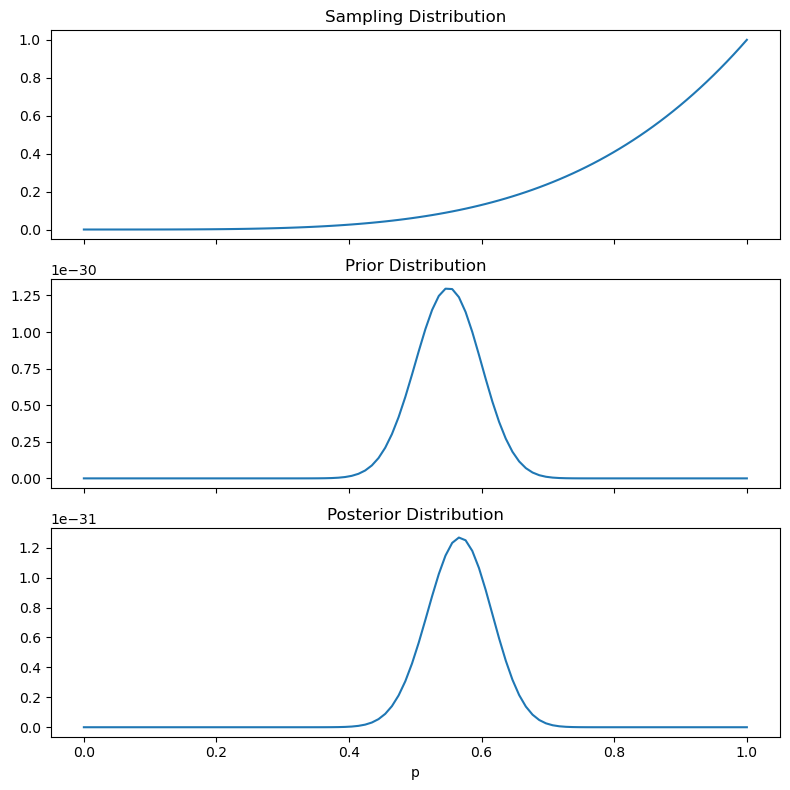

In [57]:
# Very small, skewed sample size to compare:
_ = bern_post(fair_flips=fair_flips, unfair_flips=All_tails_flip)

### Kernel Density Estimation

#### Let us randomly generate some sample points

In [58]:
def make_data(N, f=0.3, rseed=1):
    x = np.random.randn(N)
    x[int(f * N):] += 5
    return x

x = make_data(1000)

#### Let us plot a histogram of the sampled values

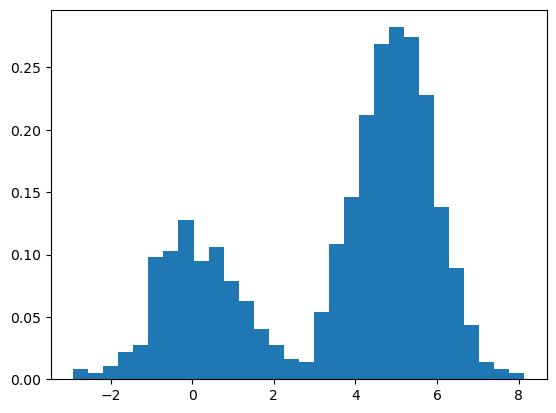

In [59]:
hist = plt.hist(x, bins=30, density=True, stacked=True)

#### Let us confirm pdf is 1.0

In [60]:
density, bins, patches = hist
widths = bins[1:] - bins[:-1]
(density * widths).sum()

1.0000000000000002

#### The choice of bin size and location can lead to representations that have qualitatively different features

In [61]:
x = make_data(20)
bins = np.linspace(-5, 10, 10)

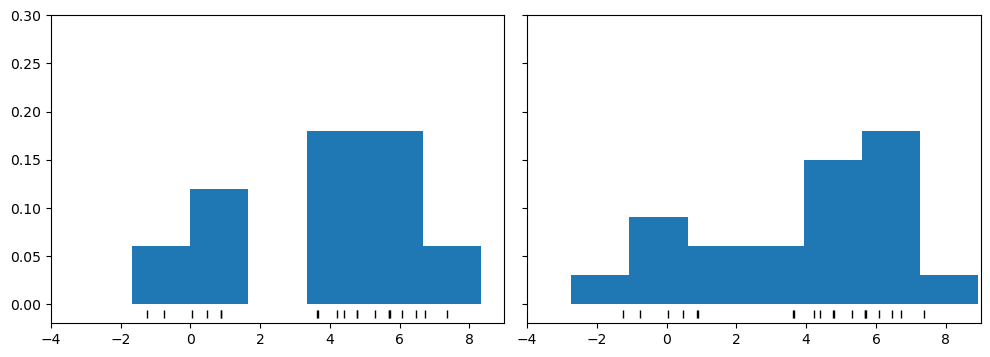

In [62]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4),
                       sharex=True, sharey=True,
                       subplot_kw={'xlim':(-4, 9),
                                   'ylim':(-0.02, 0.3)})
fig.subplots_adjust(wspace=0.05)
for i, offset in enumerate([0.0, 0.6]):
    ax[i].hist(x, bins=bins + offset, density=True, stacked=True)
    ax[i].plot(x, np.full_like(x, -0.01), '|k',
               markeredgewidth=1)

#### So rather than using a histogram, let us fit a normal at each of the sampled points

(-4.0, 8.0, -0.2, 5.0)

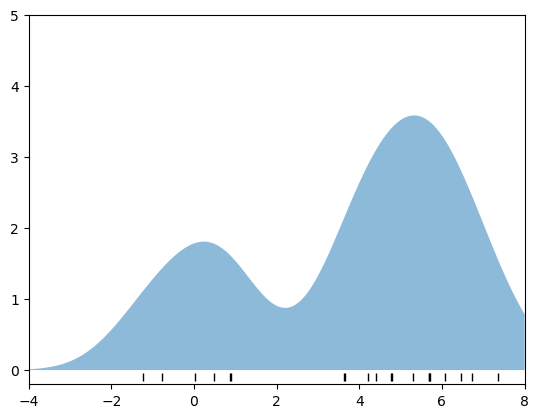

In [63]:
x_d = np.linspace(-4, 8, 1000)
density = sum(norm(xi).pdf(x_d) for xi in x)

plt.fill_between(x_d, density, alpha=0.5)
plt.plot(x, np.full_like(x, -0.1), '|k', markeredgewidth=1)

plt.axis([-4, 8, -0.2, 5])

#### We can do the same using python libraries

In [64]:
from sklearn.neighbors import KernelDensity

# instantiate and fit the KDE model
def fit_kde(bandwidth=2.0):
    kde = KernelDensity(bandwidth=bandwidth, kernel='gaussian')
    kde.fit(x[:, None])

    # score_samples returns the log of the probability density
    logprob = kde.score_samples(x_d[:, None])

    plt.fill_between(x_d, np.exp(logprob), alpha=0.5)
    plt.plot(x, np.full_like(x, -0.01), '|k', markeredgewidth=1)
    plt.title("bandwidth = " + str(bandwidth))
    plt.ylim(-0.02, 0.22)
    plt.show()

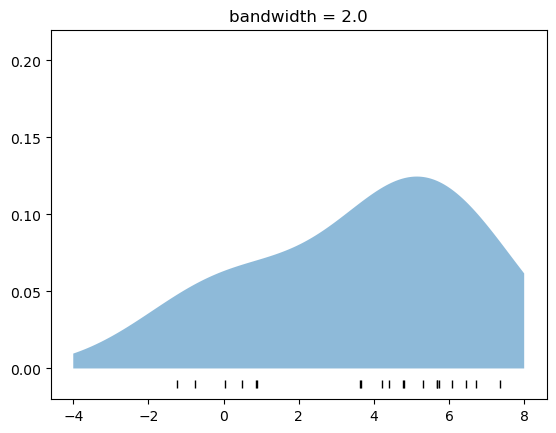

In [65]:
fit_kde()

#### The `bandwidth` is an important hyper-parameter for the kde. Lets, try running the function above with different values of bandwidth ranging from [0,2]

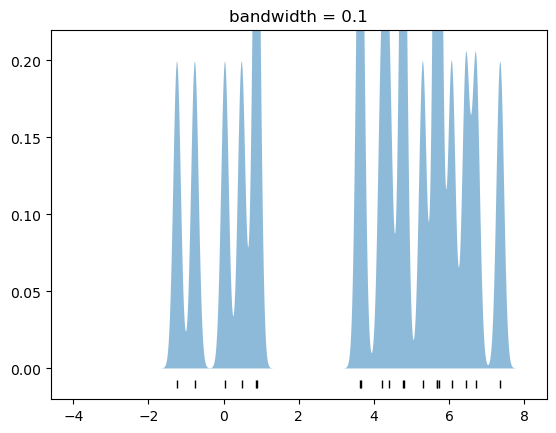

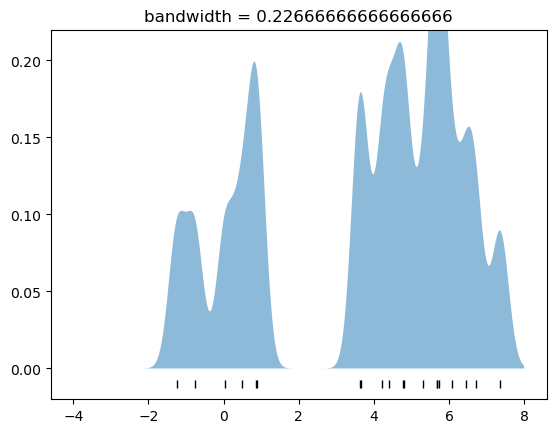

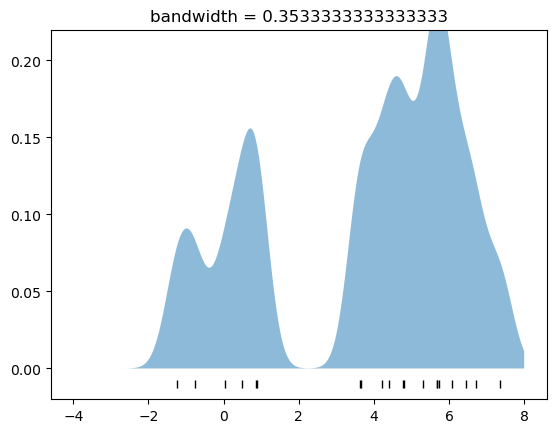

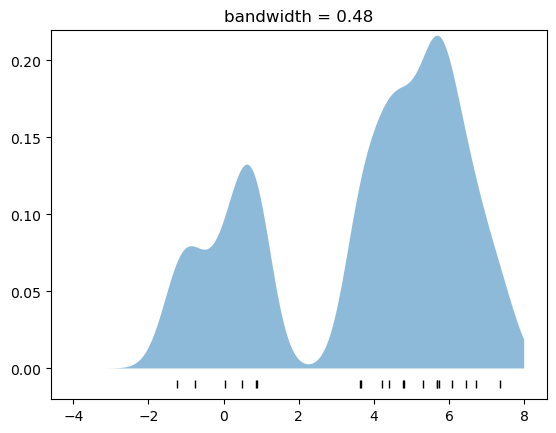

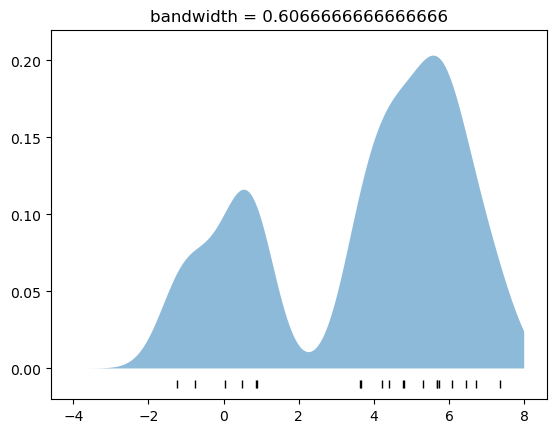

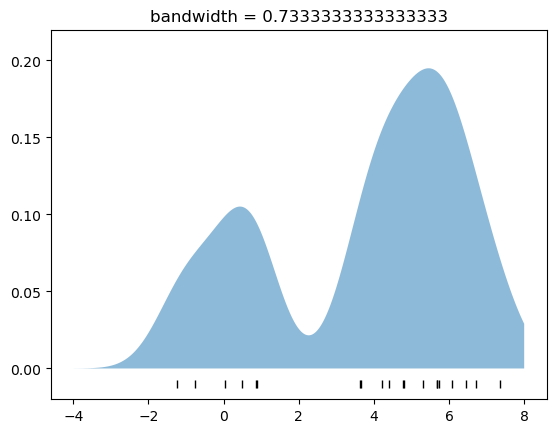

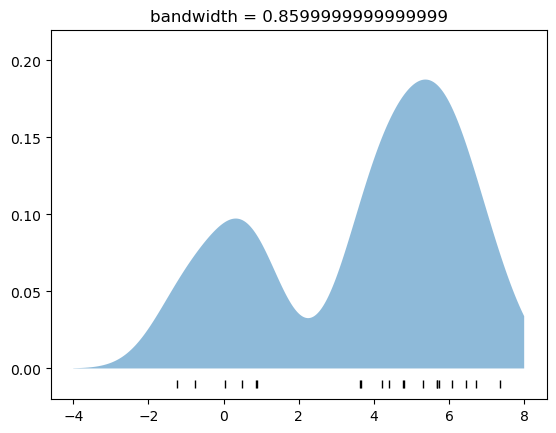

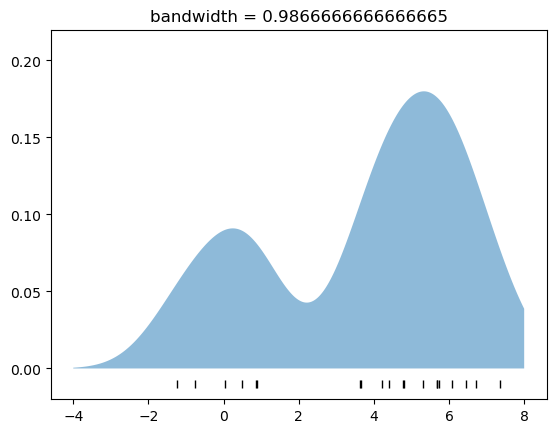

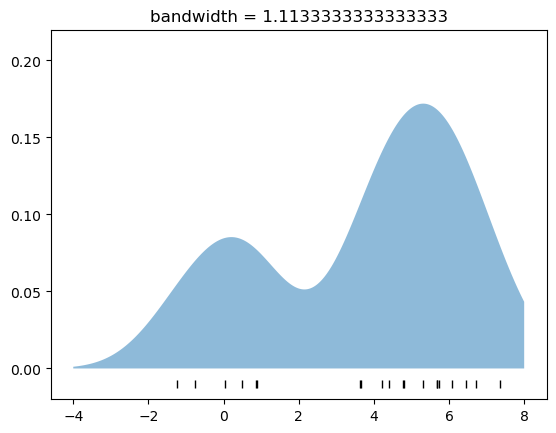

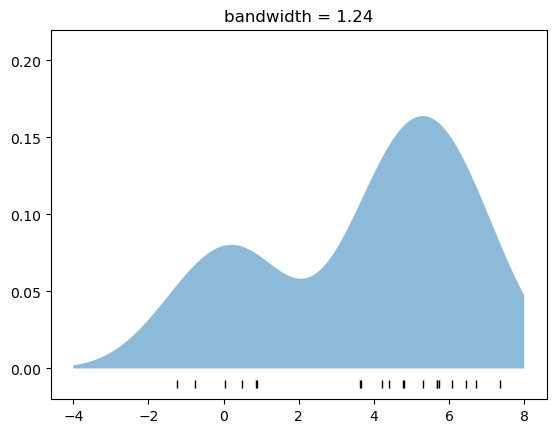

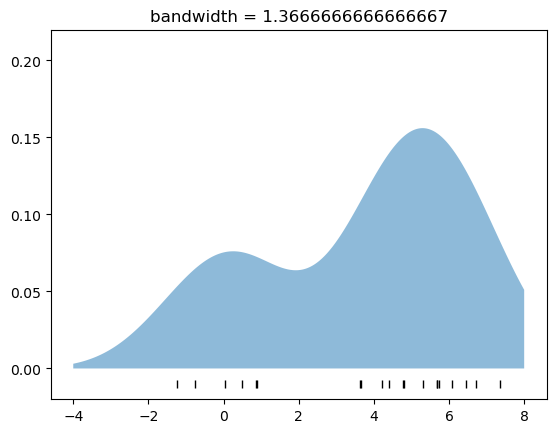

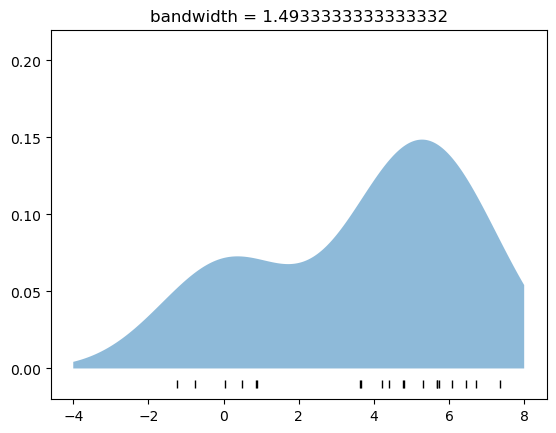

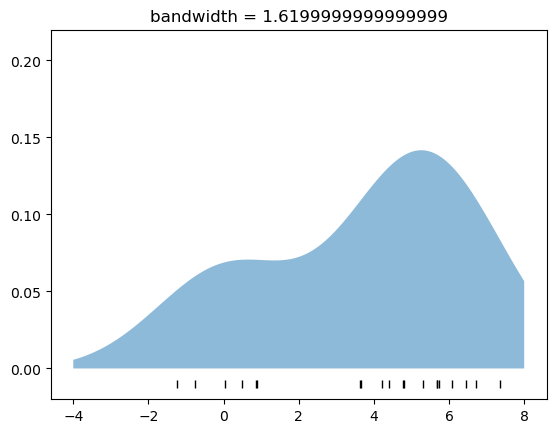

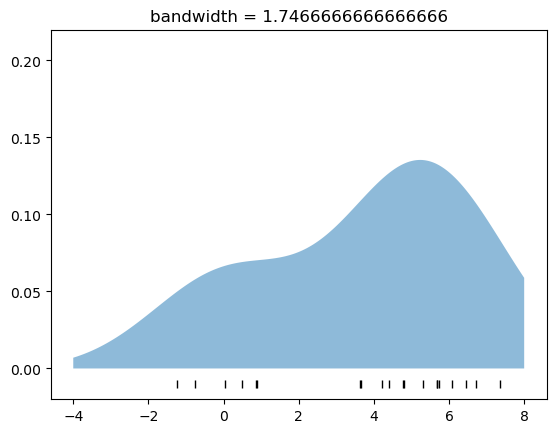

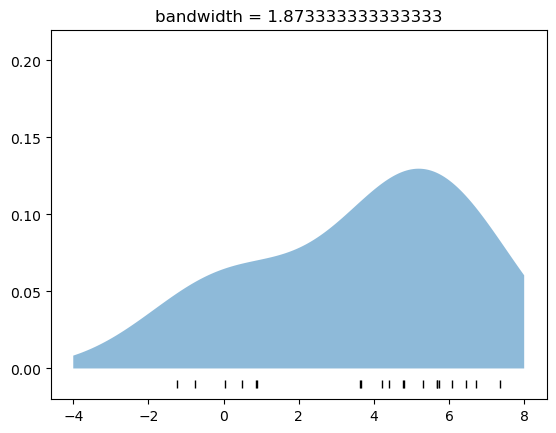

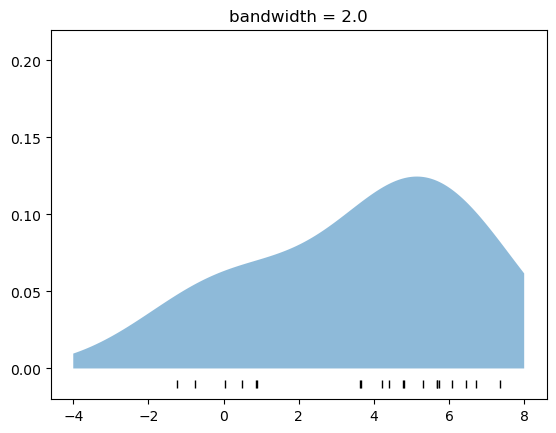

In [66]:
bandwidth_02 = np.linspace(0.1,2,16)

for bw in bandwidth_02:
    fit_kde(bandwidth = bw)

#### Let us try to find the best bandwidth using GridSearch and Idea of Cross validation

In [67]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneOut

bandwidths = 10 ** np.linspace(-1, 1, 100)
# TODO: Use GridSearch CV and Leave One out Cross validation to find the best bandwidth

grid = GridSearchCV(KernelDensity(),{'bandwidth':bandwidths}, cv = LeaveOneOut())
grid.fit(x[:, None])
best_bw = grid.best_params_
print('Best Bandwidth:' ,best_bw['bandwidth'].round(3))

Best Bandwidth: 0.811


#### Let's fit the KDE based on the best `bandwidth` value learnt

(-0.02, 0.22)

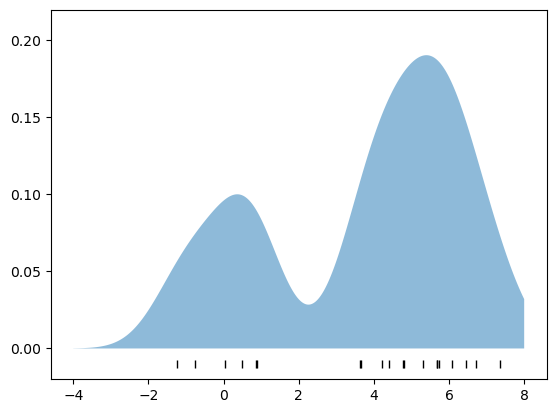

In [68]:
kde = KernelDensity(bandwidth= best_bw['bandwidth'], kernel='gaussian')
kde.fit(x[:, None])

# score_samples returns the log of the probability density
logprob = kde.score_samples(x_d[:, None])

plt.fill_between(x_d, np.exp(logprob), alpha=0.5)
plt.plot(x, np.full_like(x, -0.01), '|k', markeredgewidth=1)
plt.ylim(-0.02, 0.22)

### The Beauty of Monte Carlo Methods
#### Scenario 1: Estimate the value of pi

In [69]:
# For each input point (x,y) the function returns a boolean value indicating if the point lies
# inside the circle or outside of it.
def inside_circle(x, y):
    # The circle is centered at 0 with radius 0.5
    if  (x**2 + y**2)**0.5 <= 0.5:
        return True

   

In [70]:
# generate random numbers between 0 and 1.
def random_num_gen():
    r = np.random.rand() - 0.5 
    return r

##### The circle is inscribed in the square both centred at origin (0, 0). Lets generate random samples and keep track of the ones that fall within the circle. Keeping track of points falling within the circle approximates the area of circle. Since all samples are generated within [-0.5, 0.5], they all fall within the circle. The ratio of areas would be

area\_ratio = $\frac{\pi * \frac{a^2}{4}}{a^2}$

#### Hence, $\pi$ = 4 * area_ratio

In [71]:
# Estimate the value of pi
area_sq = 0
area_circle = 0

x_i, y_i = 0, 0
for _ in range(100000):
    x_i, y_i = random_num_gen(), random_num_gen()
    if inside_circle(x_i, y_i):
        area_circle += 1
    area_sq += 1
print(f"Value of pi is {4 * area_circle/area_sq}")

Value of pi is 3.14612


#### Optimze with increasing number of samples

Let`s try different number of sample point for estimation of pi and plot how the computed value changes with increasing number of samples

In [72]:

def pi_estimator(samples):
    area_sq = 0
    area_circle = 0

    x_i, y_i = 0, 0
    for _ in range(samples):
        x_i, y_i = random_num_gen(), random_num_gen()
        if inside_circle(x_i, y_i):
            area_circle += 1
        area_sq += 1
    pi = 4 * area_circle/area_sq
    
    return pi


samples = np.arange(1000,100000, 5000) * np.arange(1,21)

pies = []

for sample in samples:
    pii = pi_estimator(sample)
    pies.append(pii)


Text(0.5, 1.0, 'Estimating pi')

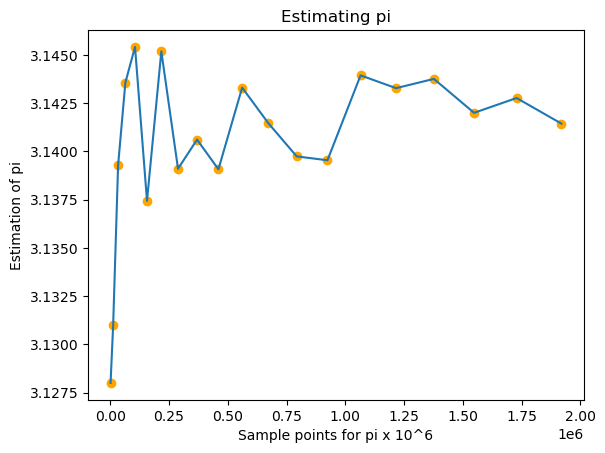

In [73]:
plt.scatter(samples, pies, color = 'orange')
plt.plot(samples, pies)
plt.xlabel('Sample points for pi x 10^6')
plt.ylabel('Estimation of pi')
plt.title('Estimating pi')